In [1]:
# import needed modules
import pandas as pd
from IPython.display import display_html
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
pd.set_option('display.max_columns', 100)
from datetime import datetime
import dataframe_image as dfi
import string

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
import itertools

### Helper functions

In [2]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [3]:
def get_weight(taa_port, strategie, histo_date):
    return taa_port[(taa_port['strategie'] == strategie) & (taa_port['histo_date'] == histo_date)][['No ISIN', 'weight']]

In [4]:
def get_all_strat(taa_port, curr=None):
    if curr is not None:
        all_strat = list(taa_port[taa_port.strategie.str.contains(curr)]['strategie'].unique())
    else:
        all_strat = list(taa_port['strategie'].unique())
        
    return all_strat

In [5]:
def get_all_isin(taa_port, curr=None, histo_date=None, strat=None):
    if curr is not None:
        if histo_date is None:
            if strat is None:
                all_isin = taa_port[taa_port['strategie'].str.contains(curr)]
            else:
                all_isin = taa_port[(taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
        else:
            all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'].str.contains(curr))]
    else:
        if histo_date is None:
            all_isin = taa_port
        else:
            all_isin = taa_port[taa_port['histo_date'] == histo_date]
        
    return pd.DataFrame(all_isin['No ISIN'].unique(), columns=['No ISIN'])

In [6]:
def sigma_to_sharp (weights, assets_annual_ret, assets_annual_cov):
    
    port_ret = weights @ assets_annual_ret
    port_vol = np.sqrt(weights.T @ assets_annual_cov @ weights )
    port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [7]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'LEUPCBC SW Index',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    #'M0UKHEUR Index': 'UKEUBH B2 Equity',
    #'M0EMHCHF Index': 'EMUC SW Equity',
    #'M0CHHEUR Index': 'CHEURIV Index',
    #'M0UKHCHF Index': 'UKCHFIV Index',
    'JPGCHFCP Index': 'EMBC SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',

    }, inplace=True)
    
    # portfolio = portfolio[
    #    ~portfolio['No ISIN'].isin([
    #    'HFRXGLC Index', 'SWIIT Index', 'SF15T Index', 
    #    'M0EMHCHF Index', 'SBR4T Index', 'H20344CH Index', 'BXCHTRCH Index', 
    #    'SBF14T Index', 'BCOMHFT Index', 'LG30TRCH Index', 
    #    'aurlnchf curncy', 'M0UKHCHF Index', 'SF51T Index'])
    # ]
    portfolio = portfolio[
        ~portfolio['No ISIN'].isin([
        'HYBRIDCHF', 'SBWG10CH Index'])]
    return portfolio

In [8]:
def get_all_date(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

### Historical price of underlying indices

In [10]:
data_excel = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])

# Historical tactical portfolio

### filtering underlying price data with available isin

In [11]:
taa_port_excel = excel_to_csv('PP_data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)
taa_port = taa_port_excel.copy()

In [14]:
taa_port['histo_date'].dt.strftime('%Y-%m-%d').unique()

array(['2019-10-11', '2019-11-13', '2019-12-13', '2020-01-16',
       '2020-02-13', '2020-03-12', '2020-04-16', '2020-05-14',
       '2020-06-10', '2020-07-16', '2020-08-20', '2020-09-17',
       '2020-10-16', '2020-11-12', '2020-12-10', '2021-01-21',
       '2021-02-26', '2021-03-17', '2021-04-19', '2021-05-18',
       '2021-06-17', '2021-08-18'], dtype=object)

In [15]:
date = '2020-01-16'
curr = 'CHF'

In [37]:
all_strategies = get_all_strat(taa_port, curr)
all_isin = get_all_isin(taa_port, curr=curr, histo_date=date)

In [38]:
# data = data.dropna()

In [39]:
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]

KeyError: "['SBWGNSUU Index', 'EMBC SW Equity', 'LEUPCBC SW Index', 'XGIUCHIV Index'] not in index"

### Historical statistics simulation with underlying prices and random portfolios

In [22]:
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

In [23]:
returns_annual * 100

H00039CH Index     3.617772
SWIIT Index        4.270659
M1US000V Index     6.256547
I02913JP Index     1.075078
NDDUPXJ Index      6.607154
CHFUSDCR Curncy    0.296271
dtype: float64

In [24]:
returns_daily.corr()

,H00039CH Index,SWIIT Index,M1US000V Index,I02913JP Index,NDDUPXJ Index,CHFUSDCR Curncy
H00039CH Index,1.000000,0.172860,0.348689,-0.057070,0.553638,0.067849
SWIIT Index,0.172860,1.000000,0.116598,-0.022998,0.147425,-0.040076
M1US000V Index,0.348689,0.116598,1.000000,-0.043622,0.305536,-0.025224
I02913JP Index,-0.057070,-0.022998,-0.043622,1.000000,-0.178685,0.056154
NDDUPXJ Index,0.553638,0.147425,0.305536,-0.178685,1.000000,0.157518
CHFUSDCR Curncy,0.067849,-0.040076,-0.025224,0.056154,0.157518,1.000000


In [25]:
cov_annual.values

array([[ 1.69720332e-03,  5.17049177e-04,  2.41140781e-03,
        -4.05597290e-05,  3.96865007e-03,  2.39695728e-04],
       [ 5.17049177e-04,  5.27158688e-03,  1.42110358e-03,
        -2.88053371e-05,  1.86248288e-03, -2.49498585e-04],
       [ 2.41140781e-03,  1.42110358e-03,  2.81793139e-02,
        -1.26325419e-04,  8.92436663e-03, -3.63086994e-04],
       [-4.05597290e-05, -2.88053371e-05, -1.26325419e-04,
         2.97600254e-04, -5.36358401e-04,  8.30702708e-05],
       [ 3.96865007e-03,  1.86248288e-03,  8.92436663e-03,
        -5.36358401e-04,  3.02761068e-02,  2.35025620e-03],
       [ 2.39695728e-04, -2.49498585e-04, -3.63086994e-04,
         8.30702708e-05,  2.35025620e-03,  7.35237891e-03]])

In [26]:
num_assets = data.shape[1]
num_portfolios = 50000

In [27]:
# Optimal Portfolio
SIGMA = cov_annual.values
INV_SIGMA = np.linalg.inv(SIGMA)
ONES = np.ones(num_assets)
MU = np.array(list(returns_annual))

A = (ONES @ INV_SIGMA) @ ONES
B = (ONES @ INV_SIGMA) @ MU
C = (MU @ INV_SIGMA) @ MU
DELTA = A * C - B**2

Mup_min = returns_annual.min()
Mup_max = returns_annual.max()
Mup = np.linspace(Mup_min,Mup_max,1000)
Sigmap = np.sqrt((A * np.multiply(Mup, Mup) - 2 * B * Mup + C) / DELTA)

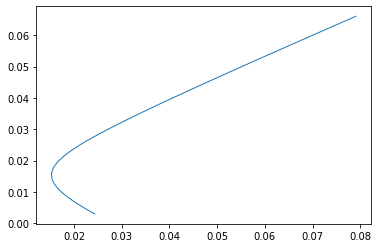

In [28]:
ax3 = sns.lineplot(x=Sigmap, y=Mup, sort=False, lw=1, palette="flare")

In [36]:
# Random Portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []

weight_list = []
for single_portfolio in tqdm(range(num_portfolios)):
    weights = np.random.choice(np.linspace(0,0.99,num_portfolios), num_assets)
    # weights = np.random.random(num_assets)
    weights = np.multiply(weights, np.random.binomial(1, 0.3, size=num_assets))
    if np.sum(weights) == 0:
        continue
    weights /= np.sum(weights)
    returns = weights @ returns_annual
    volatility = np.sqrt(weights.T @ cov_annual @ weights)
    if volatility == 0:
        continue
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    weight_list.append(weights)

  0%|          | 0/50000 [00:00<?, ?it/s]


Exception: Dot product shape mismatch, (159,) vs (6,)

In [30]:
df = pd.DataFrame(data={'returns': port_returns,
                        'volatility': port_volatility,
                        'sharpe_ratio': sharpe_ratio})
df.returns = df.returns * 100
df.volatility = df.volatility * 100
# df = df[(df.sharpe_ratio > -0.2) & (df.sharpe_ratio < 1.5) & (df.returns > -0.5)]

### Statistics of selected portfolios

#### Comparison between strategies

In [33]:
returns_annual

H00039CH Index     0.036178
SWIIT Index        0.042707
M1US000V Index     0.062565
I02913JP Index     0.010751
NDDUPXJ Index      0.066072
CHFUSDCR Curncy    0.002963
dtype: float64

In [35]:
cov_annual

,H00039CH Index,SWIIT Index,M1US000V Index,I02913JP Index,NDDUPXJ Index,CHFUSDCR Curncy
H00039CH Index,0.001697,0.000517,0.002411,-0.000041,0.003969,0.000240
SWIIT Index,0.000517,0.005272,0.001421,-0.000029,0.001862,-0.000249
M1US000V Index,0.002411,0.001421,0.028179,-0.000126,0.008924,-0.000363
I02913JP Index,-0.000041,-0.000029,-0.000126,0.000298,-0.000536,0.000083
NDDUPXJ Index,0.003969,0.001862,0.008924,-0.000536,0.030276,0.002350
CHFUSDCR Curncy,0.000240,-0.000249,-0.000363,0.000083,0.002350,0.007352


In [31]:
df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'strategie'])
date_port = date
for strat in all_strategies:
    portfolio = get_weight(taa_port, strat, date_port).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
    # print(strat)
    # print(portfolio)
    # print(portfolio.weight.sum())
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'strategie': strat}, index=[0])
    df_port = df_port.append(df_temp)
df_port.returns = df_port.returns * 100
df_port.volatility = df_port.volatility * 100

Exception: Dot product shape mismatch, (6,) vs (38,)

In [ ]:
# sns.palplot(sns.diverging_palette(220, 0, n=len(df_port)))

In [ ]:
# seaborn plot
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(16,8))
ax1 = sns.scatterplot(data=df, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.color_palette("flare_r", as_cmap=True), s=3, legend=False)
# ax2 = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='strategie', palette=sns.diverging_palette(220, 0, n=len(df_port)), s=250)
ax3 = sns.lineplot(x=Sigmap*100, y=Mup*100, sort=False, lw=1, palette="flare")
# ax2.legend().set_title(None)
plt.title('Risk/Return comparison of different strategies ; ' + date + ' ; ' + curr)
plt.xlabel('Annual Volatility (%)')
plt.ylabel('Annual Return (%)')
plt.grid()
plt.savefig('pp_output/Comparison_' + curr + '_' + date + '.png')
plt.show()


#### risk/return time evolution of a strategie

In [ ]:
curr = 'CHF'
strat = 'Equilibré' + ' ' +  curr
all_dates = get_all_date(taa_port, strat)
all_isin = get_all_isin(taa_port, curr=curr, strat=strat)

In [ ]:
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]

In [ ]:
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

In [ ]:
df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
df_port_diff = pd.DataFrame(columns=['ISIN', 'weight_diff', 'date'])

for i, date in enumerate(all_dates[range(0, len(all_dates), 3)]):
    portfolio = get_weight(taa_port, strat, date).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
    print(port_ret)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
    df_port = df_port.append(df_temp)
    if i > 0:
        df_temp2 = pd.DataFrame(data={'ISIN':list(portfolio.index),'weight_diff': (portfolio.weight - temp_port.weight)})
        df_temp2['date'] = date
        df_port_diff = df_port_diff.append(df_temp2)
    temp_port = portfolio

df_port.date = df_port.date.dt.strftime('%d/%m/%Y')
# df_port = df_port.iloc[range(0, len(df_port), 3)]
df_port.volatility = df_port.volatility * 100
df_port.returns = df_port.returns * 100
df_port['diff_ret'] = df_port.returns.diff().shift(-1)
df_port['diff_vol'] = df_port.volatility.diff().shift(-1)
df_port.sharpe_ratio = df_port.sharpe_ratio.round(4)

# df_port_diff = df_port_diff[df_port_diff.date.isin(df_port.date)]
df_port.reset_index(inplace=True, drop=True)
df_port_diff.reset_index(inplace=True, drop=True)
index = pd.MultiIndex.from_frame(df_port_diff[['date', 'ISIN']])
df_port_diff = df_port_diff.set_index(index, drop=True).drop(columns=['ISIN', 'date'])
df_port_diff['weight_diff_abs'] = df_port_diff.weight_diff.abs()
df_port_diff['weight_diff'] = df_port_diff.weight_diff * 100

In [ ]:
# seaborn plot
plt.style.use('seaborn-dark')
fig = plt.figure(figsize=(14,8))

ax = sns.scatterplot(data=df_port, x='volatility', y='returns', hue='sharpe_ratio', palette=sns.diverging_palette(0, 150, n=len(df_port), l=63), s=500, legend=True)
sns.lineplot(data=df_port, x='volatility', y='returns', sort=False, lw=1, palette="flare", zorder=1, legend=False)
x = df_port['volatility']
y = df_port['returns']
dx = df_port['diff_vol']
dy = df_port['diff_ret']
pos_x = x[:-1] + dx/2
pos_y = y[:-1] + dy/2
norm = np.sqrt(dx**2 + dy**2) 
ax2 = plt.quiver(pos_x, pos_y, dx/norm, dy/norm, angles="xy", zorder=5, pivot="mid", width=0.004)
for index, row in df_port.iterrows():
    
    x = row['volatility']
    y = row['returns']
    dx = row['diff_vol']
    dy = row['diff_ret']
    
    ax3 = plt.annotate(row['date'], xy=(x, y), xytext=(x+0.03, y-0.03), 
                 arrowprops=dict(arrowstyle="->", color='black'), annotation_clip=True)
                 
    #ax3 = plt.arrow(x, y, dx, dy, width = 0.001, length_includes_head=True, overhang=0.5,
              #shape='full', head_starts_at_zero=False, head_width=0.015, head_length=0.02, color='steelblue')

ax.legend(loc='upper left', title='Sharpe Ratio', title_fontsize=12, fontsize=11)
plt.title(label=('Risk/Return evolution through time, from ' + df_port.date.iloc[0] + " to " + df_port.date.iloc[-1] + " : " + strat), fontsize=14)
plt.xlabel(xlabel='Annual Volatility (%)', fontsize=12)
plt.ylabel(ylabel='Annual Return (%)', fontsize=12)
plt.xlim(df_port.volatility.min() - 0.15, df_port.volatility.max() + 0.1,)
plt.ylim(df_port.returns.min() - 0.05, df_port.returns.max() + 0.05)
plt.savefig('pp_output/' + str.replace(strat, ' ', '') + '.png')
plt.grid()
plt.show()


In [ ]:
# Export decision dataframe to PNG
df_diff = pd.DataFrame()
for i, (date, df) in enumerate(df_port_diff.groupby(level=0, group_keys=False)):
    df_top = df.nlargest(8, 'weight_diff_abs')['weight_diff'].to_frame().reset_index(drop=False).rename(columns={'weight_diff': 'Top Change'})
    df_top.columns = pd.MultiIndex.from_product([[df_top.date.iloc[0]], df_top.columns])
    df_top = df_top.drop('date', axis=1, level=1)
    df_diff = pd.concat([df_diff, df_top], axis=1)
dfi.export(df_diff, 'pp_output/TopMovers_' + str.replace(strat, ' ', '') + '.png')
df_diff

# Comparison of risk/return decision between different strategies

In [ ]:
curr = 'CHF'
all_strat = get_all_strat(taa_port, curr=curr)[1:]
# strat = 'Equilibré' + ' ' +  curr
all_dates = get_all_date(taa_port, strat)

In [ ]:
all_isin = get_all_isin(taa_port, curr=curr)
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]

In [ ]:
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

In [ ]:
df_vol_strats_saa = pd.DataFrame(columns=all_strat)
saa_date = '2020-12-31'

for strat in all_strat:
    
    df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
    
    portfolio = get_weight(saa_port, strat, saa_date).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                        'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
    df_port = df_port.append(df_temp)
        
    df_port.reset_index(inplace=True, drop=True)
    # df_port.date = df_port.date.dt.strftime('%d/%m/%Y')
    

df_vol_strats_saa = df_port
df_vol_strats_saa.returns *= 100
df_vol_strats_saa.volatility *= 100
# df_vol_strats_saa.index = df_port.date
# df_vol_strats_saa = df_vol_strats_saa * 100

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

saa_date = pd.to_datetime('2020-12-31')
all_dates = get_all_date(taa_port, strat)
all_dates = all_dates[range(15, len(all_dates), 1)]


for i, strat in enumerate(all_strat):
    
    # SAA
    df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
    
    portfolio = get_weight(saa_port, strat, saa_date).reset_index(drop=True)
    portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
    portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
    weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
    port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
    df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                        'sharpe_ratio': port_sharpe, 'date': saa_date}, index=[0])
    df_port = df_port.append(df_temp)
    df_port.reset_index(inplace=True, drop=True)
    df_vol_strats_saa = df_port
    
    # TAA
    df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
    for date in all_dates:
        portfolio = get_weight(taa_port, strat, date).reset_index(drop=True)
        portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
        portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
        weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
        port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
        df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
        df_port = df_port.append(df_temp)
    
    df_port.reset_index(inplace=True, drop=True)
    df_port = pd.concat([df_vol_strats_saa, df_port])
    df_port.date = df_port.date.dt.strftime('%d/%m/%Y')
    df_port.volatility = df_port.volatility - df_port.volatility.iloc[0]
    df_port.returns = df_port.returns - df_port.returns.iloc[0]
    df_port.volatility = df_port.volatility * 100
    df_port.returns = df_port.returns * 100
    # df_port['diff_ret'] = df_port.returns.diff().shift(-1)
    # df_port['diff_vol'] = df_port.volatility.diff().shift(-1)
    df_port.sharpe_ratio = df_port.sharpe_ratio.diff().fillna(0).cumsum()
    df_port['order'] = range(1,len(df_port)+1)
    #df_port.sharpe_ratio = (df_port.returns / df_port.volatility).fillna(0)
    #print(df_port)
    
    # PLOT
    n = len(df_port.volatility.unique())
    pal = sns.diverging_palette(0, 150, n=n, center='light', l=63, s=80)

    sns.lineplot(ax=axs[i], data=df_port, x='volatility', y='returns', sort=False, lw=0.5, palette="flare", zorder=1, legend=False)
    sns.scatterplot(ax=axs[i], data=df_port, x='volatility', y='returns', hue='sharpe_ratio', 
                    palette=pal, s=300, legend=False)
    
    x = df_port['volatility']
    y = df_port['returns']
    # dx = df_port['diff_vol']
    # dy = df_port['diff_ret']
    
    # pos_x = x[:-1] + dx/2
    # pos_y = y[:-1] + dy/2
    # norm = np.sqrt(dx**2 + dy**2) 
    
    # axs[i].quiver(pos_x, pos_y, dx/norm, dy/norm, angles="xy", zorder=5, pivot="mid")
    
    order_annotation = []
    for index, row in df_port.iterrows():
        x = row['volatility']
        y = row['returns']
        # dx = row['diff_vol']
        # dy = row['diff_ret']
        
        
        order_annotation.append(axs[i].annotate(row['order'], xy=(x, y), xytext=(x, y), 
                                                fontsize=10, annotation_clip=True, 
                                                ha='center', va='center', label=row['date']))
            
        #axs[i].annotate(row['date'], xy=(x, y), xytext=(x+0.1, y-0.1), 
                        #arrowprops=dict(arrowstyle="->"), annotation_clip=True)
                 
        #axs[i].arrow(x, y, dx, dy, width = 0.0003, length_includes_head=True, overhang=0.5,
                    #shape='full', head_starts_at_zero=False, head_width=0.05, head_length=0.05, color='steelblue')
    
    
    if i == 0:
        dates = list(df_port.date)
        orders = list(df_port.order)
        order_date = list(zip(orders, dates))
        text = "\n".join(list(str(x[0]) + ': ' + x[1] for x in order_date))
        axs[i].text(0.05, 0.5, text , transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
    axs[i].set_title(strat)
    axs[i].grid(b=True, which='major', color='white', linestyle='-')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)
    
fig.suptitle(' Evolution of risk/return difference with TAA and SAA at each rebalance date \n Comparison between strategies', fontsize=20, fontweight='bold')
fig.supxlabel('Absolute Volatility difference with SAA (%)', fontsize=15)
fig.supylabel('Absolute Return difference (%)', fontsize=15)
plt.savefig('pp_output/time_comparison_' + curr + '.png')
plt.show()

fig, axs = plt.subplots(2,3, figsize=(15,10), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

for i, strat in enumerate(all_strat):
    
    # DATA
    df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
    
    for date in all_dates[range(0, len(all_dates), 6)]:
        portfolio = get_weight(taa_port, strat, date).reset_index(drop=True)
        portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
        portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
        weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
        port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
        df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
        df_port = df_port.append(df_temp)
        
    df_port.reset_index(inplace=True, drop=True)
    df_port.date = df_port.date.dt.strftime('%d/%m/%Y')
    df_port.volatility = df_port.volatility - df_port.volatility.iloc[0]
    df_port.returns = df_port.returns - df_port.returns.iloc[0]
    df_port.volatility = df_port.volatility * 100
    df_port.returns = df_port.returns * 100
    df_port['diff_ret'] = df_port.returns.diff().shift(-1)
    df_port['diff_vol'] = df_port.volatility.diff().shift(-1)
    df_port.sharpe_ratio = df_port.sharpe_ratio.diff().fillna(0).cumsum()
    df_port['order'] = range(1,len(df_port)+1)
    #df_port.sharpe_ratio = (df_port.returns / df_port.volatility).fillna(0)
    #print(df_port)
    
    # PLOT
    sns.lineplot(ax=axs[i], data=df_port, x='volatility', y='returns', sort=False, lw=1, palette="flare", zorder=1, legend=False)
    sns.scatterplot(ax=axs[i], data=df_port, x='volatility', y='returns', hue='sharpe_ratio', 
                    palette=sns.diverging_palette(0, 150, n=len(df_port.sharpe_ratio.unique())), s=500, legend=False)
    
    x = df_port['volatility']
    y = df_port['returns']
    dx = df_port['diff_vol']
    dy = df_port['diff_ret']
    
    pos_x = x[:-1] + dx/2
    pos_y = y[:-1] + dy/2
    norm = np.sqrt(dx**2 + dy**2) 
    
    axs[i].quiver(pos_x, pos_y, dx/norm, dy/norm, angles="xy", zorder=5, pivot="mid")
    
    order_annotation = []
    for index, row in df_port.iterrows():
        x = row['volatility']
        y = row['returns']
        dx = row['diff_vol']
        dy = row['diff_ret']
        
        
        order_annotation.append(axs[i].annotate(row['order'], xy=(x, y), xytext=(x, y), 
                                                fontsize=15, annotation_clip=True, 
                                                ha='center', va='center', label=row['date']))
            
        #axs[i].annotate(row['date'], xy=(x, y), xytext=(x+0.1, y-0.1), 
                        #arrowprops=dict(arrowstyle="->"), annotation_clip=True)
                 
        #axs[i].arrow(x, y, dx, dy, width = 0.0003, length_includes_head=True, overhang=0.5,
                    #shape='full', head_starts_at_zero=False, head_width=0.05, head_length=0.05, color='steelblue')
    
    
    if i == 0:
        dates = list(df_port.date)
        orders = list(df_port.order)
        order_date = list(zip(orders, dates))
        text = "\n".join(list(str(x[0]) + ': ' + x[1] for x in order_date))
        axs[i].text(0.05, 0.95, text , transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        
    axs[i].set_title(strat)
    axs[i].grid(b=True, which='major', color='white', linestyle='-')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)
    
fig.suptitle(' Evolution of risk/return decisions at each rebalance date (TAA) \n Comparison between strategies', fontsize=20, fontweight='bold')
fig.supxlabel('Absolute Volatility Change (%)', fontsize=15)
fig.supylabel('Absolute Return Change (%)', fontsize=15)
plt.savefig('pp_output/time_comparison_' + curr + '.png')
plt.show()

In [ ]:
df_port

# Comparison of absolute and relative risk between strategies

In [ ]:
def volatility_comparison(all_strat, saa_date='2020-12-31'):
    
    # SAA
    df_vol_strats_saa = pd.DataFrame(columns=all_strat)
    saa_date = pd.to_datetime(saa_date)
    for strat in all_strat:

        df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
        portfolio = get_weight(saa_port, strat, saa_date).reset_index(drop=True)
        portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
        portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
        weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
        port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
        df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': saa_date}, index=[0])
        df_port = df_port.append(df_temp)

        df_port.reset_index(inplace=True, drop=True)
        df_vol_strats_saa[strat] = df_port.volatility

    df_vol_strats_saa.index = df_port.date
    df_vol_strats_saa = df_vol_strats_saa * 100

    # TAA
    df_vol_strats = pd.DataFrame(columns=all_strat)
    for i, strat in enumerate(all_strat):

        df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
        for date in all_dates[range(15, len(all_dates), 1)]:
            portfolio = get_weight(taa_port, strat, date).reset_index(drop=True)
            portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
            portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
            weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
            port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, returns_annual, cov_annual)
            df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                                'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
            df_port = df_port.append(df_temp)

        df_port.reset_index(inplace=True, drop=True)
        # df_port.date = df_port.date.dt.strftime('%d/%m/%Y')

        df_vol_strats[strat] = df_port.volatility

    df_vol_strats.index = df_port.date
    df_vol_strats = df_vol_strats * 100
    df_vol_strats_diff = df_vol_strats - df_vol_strats_saa.iloc[0]
    df_vol_strats_pct = (df_vol_strats - df_vol_strats_saa.iloc[0]) / df_vol_strats_saa.iloc[0]
    df_vol_strats_pct *= 100
    return df_vol_strats, df_vol_strats_diff, df_vol_strats_pct

In [ ]:
saa_port_excel = excel_to_csv('PP_data/saa.xlsx', 'PP', [1])
saa_port_excel.drop(columns='portfolio', inplace=True)
saa_port_excel = port_filter(saa_port_excel)

In [ ]:
taa_port_excel = excel_to_csv('PP_data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)

In [ ]:
test_pp = taa_port_excel.groupby(['strategie', 'histo_date']).sum()
test_pp = test_pp[(test_pp['weight'] < 0.999) | (test_pp['weight'] > 1.001) ]
test_pp.rename(columns={'weight':'Pondération totale extérieur à 99.9 % - 100.1 %'}, inplace=True)
test_pp.to_excel('erreur_ponderation.xlsx')

In [ ]:
taa_port_excel = port_filter(taa_port_excel)

In [ ]:
taa_port = taa_port_excel.copy()
saa_port = saa_port_excel.copy()

In [ ]:
# taa_port.groupby(['strategie', 'histo_date']).sum()

In [ ]:
all_isin = pd.concat([get_all_isin(taa_port), get_all_isin(saa_port)]).drop_duplicates()
all_dates = get_all_date(taa_port)

In [ ]:
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]

In [ ]:
tickers_data = list(data.columns)
tickers_port = list(all_isin['No ISIN'])

In [ ]:
#print('nombre ticker data', len(tickers_data))
#print('nombre ticker port', len(tickers_port))
#print(list(set(tickers_data) - set(tickers_port)))

In [ ]:
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 252
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 252

In [ ]:
# display(df_vol_strats_pct.round(2).dropna())
all_strat = ['Equilibré CHF', 'Equilibré USD', 'Equilibré EUR']
df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat)

data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%d/%m/%Y')

fig = plt.figure(figsize=(16,8))
pal = sns.color_palette("husl", 3)

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=15)

plt.ylabel(None)
plt.xlabel('volatility relative change (%)', fontsize=12)
plt.title('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between currencies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
# plt.xlim(-0.8, 0.8)
ax.grid(b=True, which='major', color='white', linestyle='-')



plt.savefig('pp_output/volatility_diff_equ.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
dfi.export(df_vol_strats_pct.round(2).dropna(), 'pp_output/volatility_diff_equ_table.png')

plt.show()

In [ ]:
# display(df_vol_strats_pct.round(2).dropna())
all_strat = ['Actions CHF', 'Actions USD', 'Actions EUR']
df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat)

data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%d/%m/%Y')

fig = plt.figure(figsize=(16,8))
pal = sns.color_palette("husl", 3)

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=15)

plt.ylabel(None)
plt.xlabel('volatility relative change (%)', fontsize=12)
plt.title('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between currencies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
# plt.xlim(-0.8, 0.8)
ax.grid(b=True, which='major', color='white', linestyle='-')



plt.savefig('pp_output/volatility_diff_actions.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
dfi.export(df_vol_strats_pct.round(2).dropna(), 'pp_output/volatility_diff_actions_table.png')

plt.show()

In [ ]:
# display(df_vol_strats_pct.round(2).dropna())
all_strat = ['Prudent CHF', 'Prudent USD', 'Prudent EUR']
df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat)

data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%d/%m/%Y')

fig = plt.figure(figsize=(16,8))
pal = sns.color_palette("husl", 3)

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=15)

plt.ylabel(None)
plt.xlabel('volatility relative change (%)', fontsize=12)
plt.title('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between currencies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
# plt.xlim(-0.8, 0.8)
ax.grid(b=True, which='major', color='white', linestyle='-')



plt.savefig('pp_output/volatility_diff_prudent.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
dfi.export(df_vol_strats_pct.round(2).dropna(), 'pp_output/volatility_diff_prudent_table.png')

plt.show()

In [ ]:
all_all_strats = ['Prudent', 'Equilibré', 'Actions']

fig, axs = plt.subplots(3,1, figsize=(16,8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

for i, all_strat in enumerate(all_all_strats):
    all_strat = [all_strat + ' CHF', all_strat + ' USD',all_strat + ' EUR']
    df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat)
    
    #subplot
    data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
    data.date = data.date.dt.strftime('%d/%m/%Y')
    
    pal = sns.color_palette("husl", 3)

    sns.scatterplot(ax=axs[i], data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

    handles, labels = axs[i].get_legend_handles_labels()
    lgd = axs[i].legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.1, 1), fontsize=10)

    
    # plt.locator_params(axis='x', nbins=15)
    axs[i].grid(b=True, which='major', color='white', linestyle='-')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)
    if i > 0:
        axs[i].set_yticklabels([])
fig.suptitle('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between currencies and strategies', fontsize=20, fontweight='bold')
fig.supxlabel('Relative Volatility difference with SAA (%)', fontsize=15)
plt.savefig('pp_output/volatility_diff_all.png')
plt.show()

In [ ]:
curr = 'CHF'
all_strat = get_all_strat(taa_port, curr=curr)
df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat)

In [ ]:
# display(df_vol_strats.round(2).dropna())

data = df_vol_strats.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%d/%m/%Y')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(220, 0, n=len(df_vol_strats_diff.columns) + 2, center='light', l=60, s=80)
del pal[3:5]

ax = sns.scatterplot(data=data, x='date', y='volatility', hue='strategie', palette=pal, s=200)
sns.lineplot(ax=ax, data=data, x='date', y='volatility', hue='strategie', palette=pal, lw=0.75, legend=False)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1, 1), fontsize=15)

plt.xlabel(None)
plt.ylabel('volatility (%)', fontsize=12)
plt.title('Evolution of the average annualized volatility at each rebalance date (TAA) \n comparison between strategies', fontweight='bold', fontsize=15)

ax.grid(b=True, which='major', color='white', linestyle='-')

plt.savefig('pp_output/volatility_evolution.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
dfi.export(df_vol_strats.round(2).dropna(), 'pp_output/volatility_evolution_table.png')

plt.show()

In [ ]:
# display(df_vol_strats_diff.round(2).dropna())

data = df_vol_strats_diff.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%d/%m/%Y')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(220, 0, n=len(df_vol_strats_diff.columns) + 2, center='light', l=60, s=80)
del pal[3:5]

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=15)

plt.ylabel(None)
plt.xlabel('volatility absolute change (%)', fontsize=12)
plt.title('Volatility absolute difference with SAA (Dec. 2020) at each rebalance date \n Comparison between strategies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
# plt.xlim(-0.4, 0.6)
ax.grid(b=True, which='major', color='white', linestyle='-')


plt.savefig('pp_output/volatility_abs_diff.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
dfi.export(df_vol_strats_diff.round(2).dropna(), 'pp_output/volatility_abs_diff_table.png')

plt.show()

In [ ]:
# display(df_vol_strats_pct.round(2).dropna())

data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%d/%m/%Y')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(220, 0, n=len(df_vol_strats_diff.columns) + 2, center='light', l=60, s=80)
del pal[3:5]

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1.2, 1), fontsize=15)

plt.ylabel(None)
plt.xlabel('volatility relative change (%)', fontsize=12)
plt.title('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between strategies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
# plt.xlim(-0.8, 0.8)
ax.grid(b=True, which='major', color='white', linestyle='-')



plt.savefig('pp_output/volatility_rel_diff.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
dfi.export(df_vol_strats_pct.round(2).dropna(), 'pp_output/volatility_rel_diff_table.png')

plt.show()

# Comparison of historical performance between strategies

In [ ]:
def get_conf_interval(df):
    df['mean'] = df.iloc[:, 0].rolling(window).mean()
    df['std'] = 2 * df.iloc[:, 0].rolling(window).std()
    df.dropna(inplace=True)
    df['bottom'] = df['mean'] - df_strat_price['std']
    df['top'] = df['mean'] + df_strat_price['std']
    return df

In [ ]:
taa_port = taa_port_excel.copy()
window = 30
all_strat = get_all_strat(taa_port, curr='CHF')
colors = sns.diverging_palette(220, 0, n=len(all_strat)+2)
del colors[3:5]
fig = plt.figure(figsize=(16, 10))

for i, strat in enumerate(all_strat):
    df_weight = taa_port[taa_port.strategie == strat].drop(columns='strategie').drop_duplicates()
    df_weight = df_weight.pivot(index='histo_date', columns='No ISIN', values='weight').fillna(0)
    all_isin = list(df_weight.columns)
    data = data_excel.copy()
    data = data[all_isin]
    data = data.iloc[2000:]
    df_weight = pd.merge(data.drop(columns=data.columns), df_weight, how='left', left_index=True, right_index=True).fillna(method='bfill').dropna(how='all')
    data = data.loc[:df_weight.index[-1]]
    df_strat_price = (100 * (1 + data.pct_change().mul(df_weight).sum(axis=1)).cumprod()).to_frame().rename(columns={0:'price'})
    # df_strat_price = (100 * (1 + data.pct_change().mul(df_weight).sum(axis=1).cumsum())).to_frame().rename(columns={0:'price'})
    df_strat_bollinger = get_conf_interval(df_strat_price)
    sns.lineplot(data=df_strat_bollinger, x=df_strat_bollinger.index, y='mean', lw=1.5, label=strat, color=colors[i])
    plt.fill_between(df_strat_bollinger.index, df_strat_price['bottom'], df_strat_bollinger['top'], color=colors[i], alpha=0.2)

plt.legend(fontsize=12)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NAV Price', fontsize=15)
plt.title('Performance comparison between strategies ; ' + curr + '\n from ' + str(df_strat_price.index.date[0]) + ' to ' + str(df_strat_price.index.date[-1]), 
          fontsize=15, fontweight='bold')
plt.grid()
plt.savefig('pp_output/performance_comparison.png')
plt.show()
    

### DRAFT

for i, (date, df) in enumerate(df_port_diff.groupby(level=0, group_keys=False)):
    df_top = df.nlargest(5, 'weight_diff_abs')['weight_diff'].to_frame().rename(columns={'weight_diff':'Top 5 movers'})
    string_date = date.to_pydatetime().strftime("%d.%m.%Y")
    dfi.export(df_top, 'pp_output/TopMovers_' + string_date + '_' + str.replace(strat, ' ', '') + '.png')
    

df_port_diff_grouped = df_port_diff.groupby(level=0, group_keys=False).apply(lambda x: x.nlargest(5, 'weight_diff_abs'))['weight_diff'].to_frame()

count = 0
count_temp = 0

for i, (date, df) in enumerate(df_port_diff.groupby(level=0, group_keys=False)):
    df_top = df.nlargest(5, 'weight_diff_abs')['weight_diff'].to_frame().rename(columns={'weight_diff':'Top 5 movers'})
    if count == 0:
        df0 = df_top
        if i == len(df_port_diff.groupby(level=0)) -1 :
            df0_styler = df0.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
            # display_html(df0_styler._repr_html_(), raw=True)
        count_temp += 1
    if count == 1:
        df1 = df_top
        if i == len(df_port_diff.groupby(level=0)) -1 :
            df1_styler = df1.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
            # display_html(df0_styler._repr_html_() + df1_styler._repr_html_(), raw=True)
        count_temp += 1
    if count == 2:
        df2 = df_top
        df0_styler = df0.style.format(formatter={'Top 5 movers': "{:.2f}", 'date': "{:%Y/%m}"}).set_table_attributes("style='display:inline'")
        df1_styler = df1.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
        df2_styler = df2.style.format(formatter={('Top 5 movers'): "{:.2f}"}).set_table_attributes("style='display:inline'")
        # display_html(df0_styler.render() + df1_styler._repr_html_() + df2_styler.render(), raw=True)
        count_temp = 0
    count = count_temp

In [ ]:
taa_port = excel_to_csv('PP_data/pp_histo.xlsx', 'PP')
taa_port.drop(columns='portfolio', inplace=True)
taa_port['No ISIN'].replace({
    
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'LEUPCBC SW Index',
    'Cat Bond EUR': 'LEUPCBE SW Index'
    
    }, inplace=True)

In [ ]:
ALL = pd.DataFrame(taa_port['No ISIN'].unique(), columns=['No ISIN'])

In [ ]:
ALL

In [ ]:
data = pd.read_excel('PP_data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])

In [ ]:
data.rename(columns = { data.columns[0]: "Dates" }, inplace = True)
data['Dates'] = pd.to_datetime(data['Dates'], yearfirst=True, format="%d/%m/%Y")
data = data.fillna(method='ffill')
data.index = data['Dates']
data = data.drop(columns=['Dates', 'HYBRIDCHF'])

In [ ]:
data = data[ALL['No ISIN']]

In [ ]:
all_isin = get_all_isin(taa_port, curr='USD', histo_date='2021-08-18')

In [ ]:
portfolio = get_weight(taa_port, 'Dynamique USD', '2021-08-18').reset_index(drop=True)

In [ ]:
portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0)
portfolio

In [ ]:
portfolio['No ISIN'].replace({
    
    'Inflation Bond CHF': 'XGIUCHIV Index',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'INSYBZE Index',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'MRSGCAH LX Index',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat bond USD': 'LEUPCBU SW Index',
    'Cat bond CHF': 'LEUPCBC SW Index',
    'Cat bond EUR': 'LEUPCBE SW Index'
    
    }, inplace=True)

In [ ]:
portfolio = portfolio[~portfolio['No ISIN'].isin(['HFRXGLC Index', 'SWIIT Index', 'SF15T Index', 
 'M0EMHCHF Index', 'SBR4T Index', 'H20344CH Index', 'BXCHTRCH Index', 
 'SBF14T Index', 'BCOMHFT Index', 'LG30TRCH Index', 
 'aurlnchf curncy', 'M0UKHCHF Index', 'UCBIFX28 Index', 'SF51T Index'])]

In [ ]:
portfolio.weight = portfolio.weight / np.sum(portfolio.weight)
portfolio

In [ ]:
port_weights = np.array(portfolio['weight'])

In [ ]:
data = data[list(portfolio['No ISIN'])]

In [ ]:
data.head()

In [ ]:
port_sharp = sigma_to_sharp(port_weights, returns_annual, cov_annual)